In [1]:
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## function to make heatmap
def plot_heatmaps(data_dict, sim, cmap=None):
    ## Calling cards signal
    data = np.zeros((10,160))
    for i in range(10):
        for j in range(20):
            if data_dict["cc_"+sim][str(i)]["loss"][j] < 0:
                data[i,data_dict["cc_"+sim][str(i)]["indx"][j]] = data_dict["cc_"+sim][str(i)]["loss"][j]
    ## normalize 
    data_norm = data / (-np.min(data,axis=1).reshape(-1,1))
#     data_norm = data
    ## plot
    plt.figure(num=None, figsize=(8,3), dpi=150)
    ax = sns.heatmap(data_norm, cmap=cmap)
    ax.set_xlabel("Dist of CC signal to ATG")
    ax.set_ylabel("CV fold")
    ax.set_xticklabels(800-25*np.arange(160), rotation=60, ha='right')
    plt.show()
    
    ## Histone marks
    data = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            if data_dict["hm_"+sim][str(i)]["loss"][j] < 0:
                data[i,data_dict["hm_"+sim][str(i)]["indx"][j]] = data_dict["hm_"+sim][str(i)]["loss"][j]
    ## normalize 
    data_norm = data / (-np.min(data,axis=1).reshape(-1,1))
#     data_norm = data
    ## plot
    plt.figure(num=None, figsize=(4,3), dpi=150)
    ax = sns.heatmap(data_norm, cmap=cmap)
    ax.set_xlabel("Histone marks")
    ax.set_ylabel("CV fold")
    hms = ['H3K27ac_prom_-1','H3K36me3_prom_-1',
            'H3K4me3_prom_-1','H3K79me_prom_-1',
            'H4K16ac_prom_-1','H3K27ac_body',
            'H3K36me3_body','H3K4me3_body',
            'H3K79me_body','H4K16ac_body']
    ax.set_xticklabels(hms, rotation=60, ha='right')
    plt.show()

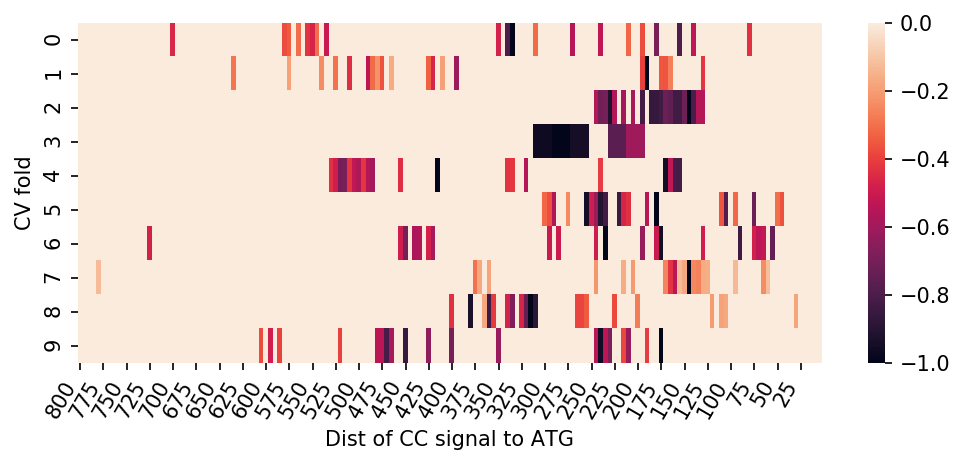

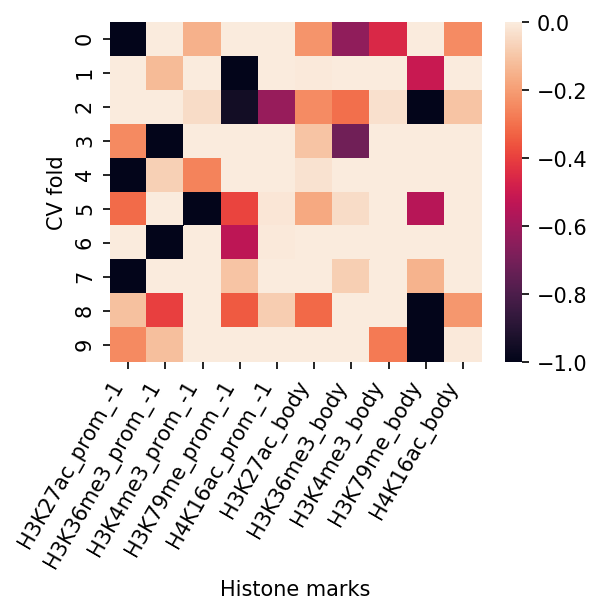

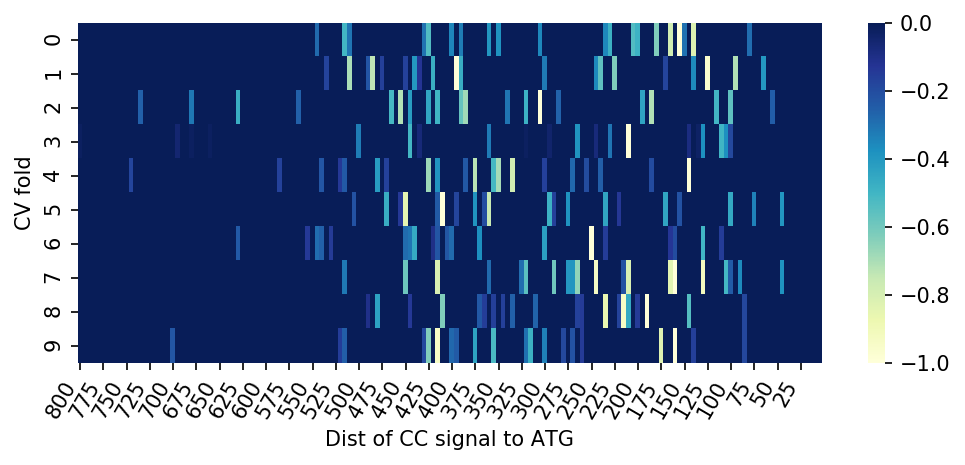

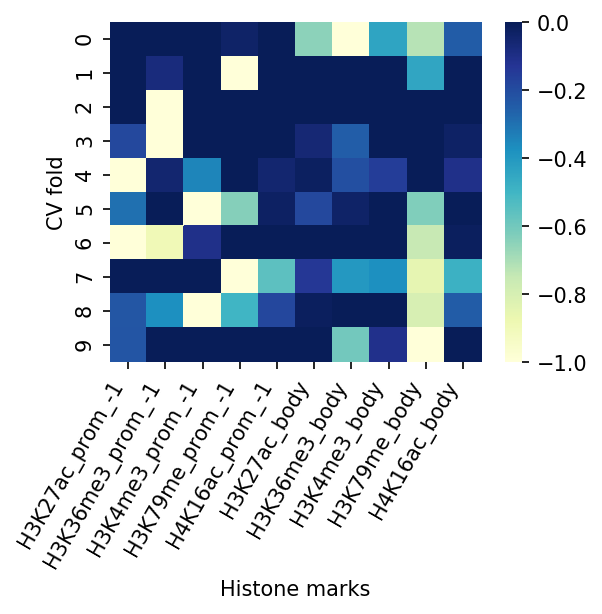

In [3]:
## load CNN data
with open("../output4/multiTF_feature_ranking.cnn.json", "r") as fp:
    cnn_dict = json.load(fp)
plot_heatmaps(cnn_dict, "high")
plot_heatmaps(cnn_dict, "low", "YlGnBu")

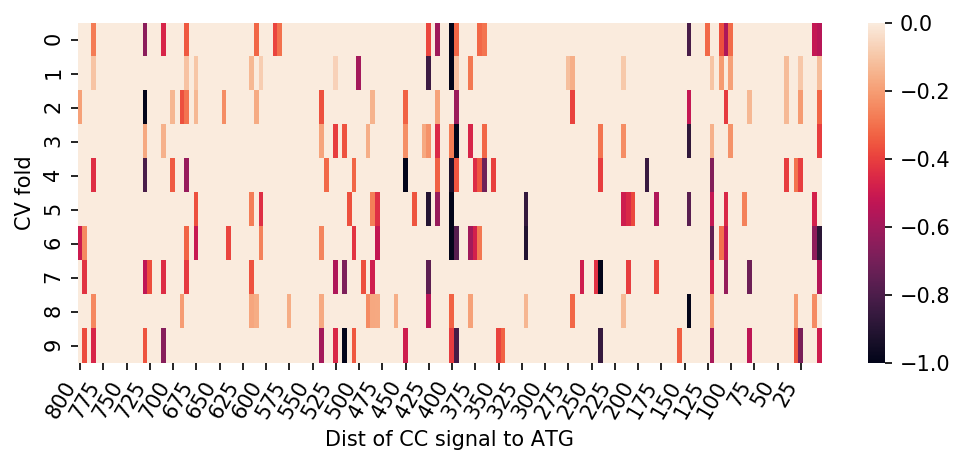

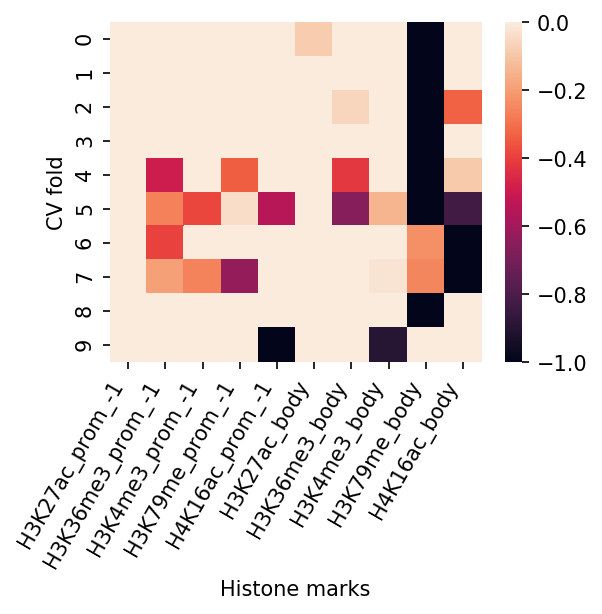

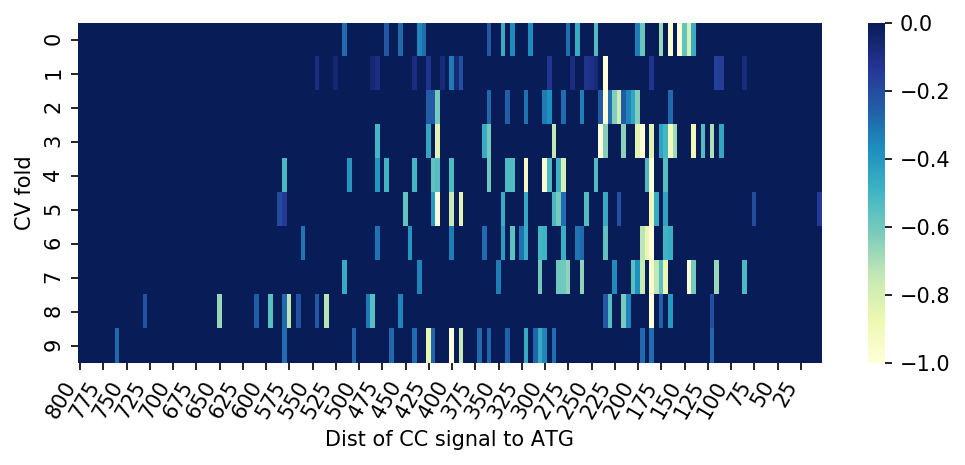

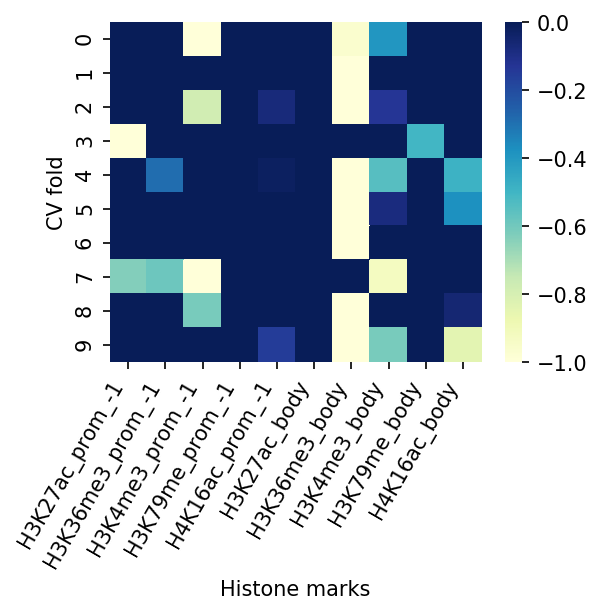

In [4]:
## load RF data
with open("../output4/multiTF_feature_ranking.rf.json", "r") as fp:
    rf_dict = json.load(fp)
plot_heatmaps(rf_dict, "high")
plot_heatmaps(rf_dict, "low", "YlGnBu")